**This post was originally published as a tutorial for DataCamp [here][datacamp_post] on September 12 2017** using NetworkX **1.11**.  On September 20 2017, NetworkX [announced] the release of a new version **2.0**, after two years in the making.  While **2.0** introduces lots of great features (some have already been used to improve this project in [postman_problems]), it also introduced backwards incompatible API changes that broke the original tutorial :(.  I've commented out lines deprecated by **2.0** and tagged with `# deprecated after NX 1.11`, so the changes made here are explicit.  Most of the changes are around the passing and setting of attributes and return values deprecating lists for generators.

So... **TL;DR:**

1. This is the NetworkX **2.0** compatible version of the Chinese Postman DataCamp tutorial originally posted [here].
2. The ideas introduced in this tutorial are packaged into the [postman_problems] library which is the mature implementation of these concepts.  

**A note on the making of this post**.  The original post was created in a Jupyter notebook and converted to HTML with some style tweaks by the DataCamp publishing team.  This post was converted from an [updated notebook] to a Jekyll flavored markdown document for my blog using [nb2jekyll] with just a few [tweaks of my own].  This was the first Jupyter notebook I've converted to a blog post, but the conversion was smoother than I might have expected.  I would recommend [nb2jekyll] and [this post] to comrade Jekyll bloggers looking to generate posts directly from Jupyter notebooks.

[datacamp_post]: https://www.datacamp.com/community/tutorials/networkx-python-graph-tutorial
[announced]: https://networkx.github.io/documentation/stable/release/release_2.0
[postman_problems]: https://github.com/brooksandrew/postman_problems
[updated notebook]: https://github.com/brooksandrew/simpleblog/tree/gh-pages/_ipynb
[nb2jekyll]: https://github.com/jsoma/nb2jekyll
[tweaks of my own]: https://github.com/brooksandrew/simpleblog/tree/gh-pages/nb2jekyll
[this post]: http://rjbaxley.com/posts/2017/02/25/Jekyll_Blogging_with_Notebooks.html

----------

## Intro to Graph Optimization with NetworkX in Python

### Solving the Chinese Postman Problem

With this tutorial, you'll tackle an established problem in graph theory called the Chinese Postman Problem. There are some components of the algorithm that while conceptually simple, turn out to be computationally rigorous. However, for this tutorial, only some prior knowledge of Python is required: no rigorous math, computer science or graph theory background is needed.

This tutorial will first go over the basic building blocks of graphs (nodes, edges, paths, etc) and solve the problem on a real graph (trail network of a state park) using the [NetworkX] library in Python. You'll focus on the core concepts and implementation.  For the interested reader, further reading on the guts of the optimization are provided.

[NetworkX]:https://networkx.github.io/

* TOC
{:toc}

## Motivating Graph Optimization

### The Problem

You've probably heard of the [Travelling Salesman Problem] which amounts to finding the shortest route (say, roads) that connects a set of nodes (say, cities).  Although lesser known, the [Chinese Postman Problem] (CPP), also referred to as the Route Inspection or Arc Routing problem, is quite similar.  The objective of the CPP is to find the shortest path that covers all the links (roads) on a graph at least once.  If this is possible without doubling back on the same road twice, great; That's the ideal scenario and the problem is quite simple.  However, if some roads must be traversed more than once, you need some math to find the shortest route that hits every road at least once with the lowest total mileage.  

[NetworkX]:https://networkx.github.io/
[Travelling Salesman Problem]:https://en.wikipedia.org/wiki/Travelling_salesman_problem
[Chinese Postman Problem]: https://en.wikipedia.org/wiki/Route_inspection_problem

### Personal Motivation

_(The following is a personal note: cheesy, cheeky and 100% not necessary for learning graph optimization in Python)_

I had a real-life application for solving this problem: attaining the rank of Giantmaster Marathoner.  

What is a Giantmaster?  A [Giantmaster] is one (canine or human) who has hiked every trail of Sleeping Giant State Park in Hamden CT (neighbor to my hometown of Wallingford)... in their lifetime.  A Giantmaster Marathoner is one who has hiked all these trails in a single day.  

Thanks to the fastidious record keeping of the Sleeping Giant Park Association, the full roster of Giantmasters and their level of Giantmastering can be found [here].  I have to admit this motivated me quite a bit to kick-start this side-project and get out there to run the trails.  While I myself achieved Giantmaster status in the winter of 2006 when I was a budding young volunteer of the Sleeping Giant Trail Crew (which I was pleased to see recorded in the [SG archive]), new challenges have since arisen.  While the 12-month and 4-season Giantmaster categories are impressive and enticing, they'd also require more travel from  my current home (DC) to my formative home (CT) than I could reasonably manage... and they're not as interesting for graph optimization, so Giantmaster Marathon it is!

For another reference, the Sleeping Giant trail map is provided below:


[Giantmaster]:http://www.sgpa.org/hikes/masters.html
[SG archive]:http://www.sgpa.org/gnews/archive/84.pdf
[here]:http://www.sgpa.org/hikes/master-list.htm
[postman_problems]:https://github.com/brooksandrew/postman_problems

In [51]:
from IPython.display import IFrame, HTML  # TODO: Remove this cell when the PDF is embedded directly within HTML
IFrame("http://www.ct.gov/deep/lib/deep/stateparks/maps/sleepgiant.pdf", width=600, height=450)

## Introducing Graphs

The nice thing about graphs is that the concepts and terminology are generally intuitive.  Nonetheless, here's some of the basic lingo: 

**Graphs** are structures that map relations between objects.  The objects are referred to as **nodes** and the connections between them as **edges** in this tutorial.  Note that edges and nodes are commonly referred to by several names that generally mean exactly the same thing:

```
node == vertex == point
edge == arc == link
```

The starting graph is **undirected**.  That is, your edges have no orientation: they are **bi-directional**.  For example: `A<--->B == B<--->A`.  
By contrast, the graph you might create to specify the shortest path to hike every trail could be a **directed graph**, where the order and direction of edges matters.  For example: `A--->B != B--->A`.

The graph is also an **edge-weighted graph** where the distance (in miles) between each pair of adjacent nodes represents the weight of an edge.  This is handled as an **edge attribute** named "distance".

**Degree** refers to the number of edges incident to (touching) a node.  Nodes are referred to as **odd-degree nodes** when this number is odd and **even-degree** when even.

The solution to this CPP problem will be a **Eulerian tour**: a graph where a cycle that passes through every edge exactly once can be made from a starting node back to itself (without backtracking).  An Euler Tour is also known by several names:

```
Eulerian tour == Eulerian circuit == Eulerian cycle
```

A **matching** is a subset of edges in which no node occurs more than once.  A **minimum weight matching** finds the **matching** with the lowest possible summed edge weight.

### NetworkX: Graph Manipulation and Analysis

NetworkX is the most popular Python package for manipulating and analyzing graphs.  Several packages offer the same basic level of graph manipulation, notably igraph which also has bindings for R and C++.  However, I found that NetworkX had the strongest graph algorithms that I needed to solve the CPP.

### Installing Packages

If you've done any sort of data analysis in Python or have the Anaconda distribution, my guess is you probably have `pandas` and `matplotlib`.  However, you might not have `networkx`.  These should be the only dependencies outside the Python Standard Library that you'll need to run through this tutorial.  They are easy to install with `pip`:

```
pip install pandas
pip install networkx>=2.0
pip install matplotlib
```

These should be all the packages you'll need for now.  `imageio` and `numpy` are imported at the very end to create the GIF animation of the CPP solution.  The animation is embedded within this post, so these packages are optional.

In [52]:
import itertools
import copy
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt

## Load Data

### Edge List

The edge list is a simple data structure that you'll use to create the graph.  Each row represents a single edge of the graph with some edge attributes.  

* **node1** & **node2:** names of the nodes connected. 
* **trail:** edge attribute indicating the abbreviated name of the trail for each edge. For example: *rs = red square*
* **distance:** edge attribute indicating trail length in miles.
* **color**: trail color used for plotting.
* **estimate:** edge attribute indicating whether the edge distance is estimated from eyeballing the trailmap (*1=yes*, *0=no*) as some distances are not provided.  This is solely for reference; it is not used for analysis.


In [53]:
# Grab edge list data hosted on Gist
edgelist = pd.read_csv('https://gist.githubusercontent.com/brooksandrew/e570c38bcc72a8d102422f2af836513b/raw/89c76b2563dbc0e88384719a35cba0dfc04cd522/edgelist_sleeping_giant.csv') 

In [54]:
# Preview edgelist
edgelist.head(10)

,node1,node2,trail,distance,color,estimate
0,rs_end_north,v_rs,rs,0.30,red,0
1,v_rs,b_rs,rs,0.21,red,0
2,b_rs,g_rs,rs,0.11,red,0
3,g_rs,w_rs,rs,0.18,red,0
4,w_rs,o_rs,rs,0.21,red,0
5,o_rs,y_rs,rs,0.12,red,0
6,y_rs,rs_end_south,rs,0.39,red,0
7,rc_end_north,v_rc,rc,0.70,red,0
8,v_rc,b_rc,rc,0.04,red,0
9,b_rc,g_rc,rc,0.15,red,0


### Node List

Node lists are usually optional in `networkx` and other graph libraries when edge lists are provided because the node names are provided in the edge list's first two columns.  However, in this case, there are some node attributes that we'd like to add: X, Y coordinates of the nodes (trail intersections) so that you can plot your graph with the same layout as the trail map.  

I spent an afternoon annotating these manually by tracing over the image with [GIMP]:

* **id:** name of the node corresponding to **node1** and **node2** in the edge list.
* **X:** horizontal position/coordinate of the node relative to the topleft.
* **Y** vertical position/coordinate of the node relative to the topleft.

### Note on Generating the Node & Edge Lists

Creating the node names also took some manual effort.  Each node represents an intersection of two or more trails.  Where possible, the node is named by *trail1_trail2* where *trail1* precedes *trail2* in alphabetical order.  

Things got a little more difficult when the same trails intersected each other more than once.  For example, the Orange and White trail.  In these cases, I appended a *_2* or *_3* to the node name.  For example, you have two distinct node names for the two distinct intersections of Orange and White: *o_w* and *o_w_2*.  

This took a lot of trial and error and comparing the plots generated with X,Y coordinates to the real trail map.

[GIMP]:https://www.gimp.org/

In [55]:
# Grab node list data hosted on Gist
nodelist = pd.read_csv('https://gist.githubusercontent.com/brooksandrew/f989e10af17fb4c85b11409fea47895b/raw/a3a8da0fa5b094f1ca9d82e1642b384889ae16e8/nodelist_sleeping_giant.csv')

In [56]:
# Preview nodelist
nodelist.head(5)

,id,X,Y
0,b_bv,1486,732
1,b_bw,716,1357
2,b_end_east,3164,1111
3,b_end_west,141,1938
4,b_g,1725,771


## Create Graph

Now you use the edge list and the node list to create a graph object in `networkx`.

In [57]:
# Create empty graph
g = nx.Graph()

Loop through the rows of the edge list and add each edge and its corresponding attributes to graph `g`.

In [58]:
# Add edges and edge attributes
for i, elrow in edgelist.iterrows():
    # g.add_edge(elrow[0], elrow[1], attr_dict=elrow[2:].to_dict())  # deprecated after NX 1.11
    g.add_edge(elrow[0], elrow[1], **elrow[2:].to_dict())

To illustrate what's happening here, let's print the values from the last row in the edge list that got added to graph `g`:

In [59]:
# Edge list example
print(elrow[0]) # node1
print(elrow[1]) # node2
print(elrow[2:].to_dict()) # edge attribute dict

o_gy2
y_gy2
{'estimate': 0, 'distance': 0.12, 'color': 'yellowgreen', 'trail': 'gy2'}


Similarly, you loop through the rows in the node list and add these node attributes.

In [60]:
# Add node attributes
for i, nlrow in nodelist.iterrows():
    # g.node[nlrow['id']] = nlrow[1:].to_dict()  # deprecated after NX 1.11
    nx.set_node_attributes(g, {nlrow['id']:  nlrow[1:].to_dict()})  


Here's an example from the last row of the node list:

In [61]:
# Node list example
print(nlrow)

id    y_rt
X      977
Y     1666
Name: 76, dtype: object


## Inspect Graph

### Edges

Your graph edges are represented by a list of tuples of length 3.  The first two elements are the node names linked by the edge. The third is the dictionary of edge attributes.

In [62]:
# Preview first 5 edges

# g.edges(data=True)[0:5]  # deprecated after NX 1.11
list(g.edges(data=True))[0:5] 

[('v_end_west',
  'b_v',
  {'color': 'violet', 'distance': 0.13, 'estimate': 0, 'trail': 'v'}),
 ('rt_end_north',
  'v_rt',
  {'color': 'red', 'distance': 0.3, 'estimate': 0, 'trail': 'rt'}),
 ('b_o',
  'park_east',
  {'color': 'orange', 'distance': 0.11, 'estimate': 0, 'trail': 'o'}),
 ('b_o',
  'o_gy2',
  {'color': 'orange', 'distance': 0.06, 'estimate': 0, 'trail': 'o'}),
 ('b_o',
  'b_y',
  {'color': 'blue', 'distance': 0.08, 'estimate': 0, 'trail': 'b'})]

### Nodes

Similarly, your nodes are represented by a list of tuples of length 2. The first element is the node ID, followed by the dictionary of node attributes.

In [63]:
# Preview first 10 nodes

# g.nodes(data=True)[0:10]  # deprecated after NX 1.11
list(g.nodes(data=True))[0:10] 

[('v_end_west', {'X': 359, 'Y': 1976}),
 ('rt_end_north', {'X': 681, 'Y': 850}),
 ('b_o', {'X': 2039, 'Y': 1012}),
 ('rh_end_north', {'X': 205, 'Y': 1472}),
 ('rh_end_tt_1', {'X': 558, 'Y': 1430}),
 ('o_y_tt_end_west', {'X': 459, 'Y': 1924}),
 ('w_rt', {'X': 926, 'Y': 1490}),
 ('b_rd_dupe', {'X': 268, 'Y': 1744}),
 ('b_tt_2', {'X': 857, 'Y': 1287}),
 ('rd_end_south_dupe', {'X': 273, 'Y': 1869})]

### Summary Stats

Print out some summary statistics before visualizing the graph. 

In [64]:
print('# of edges: {}'.format(g.number_of_edges()))
print('# of nodes: {}'.format(g.number_of_nodes()))

# of edges: 123
# of nodes: 77


## Visualize 

### Manipulate Colors and Layout

**Positions:** First you need to manipulate the node positions from the graph into a dictionary.  This will allow you to recreate the graph using the same layout as the actual trail map.  `Y` is negated to transform the Y-axis origin from the topleft to the bottomleft.

In [65]:
# Define node positions data structure (dict) for plotting
node_positions = {node[0]: (node[1]['X'], -node[1]['Y']) for node in g.nodes(data=True)}

# Preview of node_positions with a bit of hack (there is no head/slice method for dictionaries).
dict(list(node_positions.items())[0:5])

{'b_o': (2039, -1012),
 'rh_end_north': (205, -1472),
 'rh_end_tt_1': (558, -1430),
 'rt_end_north': (681, -850),
 'v_end_west': (359, -1976)}

**Colors:** Now you manipulate the edge colors from the graph into a simple list so that you can visualize the trails by their color.

In [66]:
# Define data structure (list) of edge colors for plotting

# edge_colors = [e[2]['color'] for e in g.edges(data=True)]  # deprecated after NX 1.11
edge_colors = [e[2]['color'] for e in list(g.edges(data=True))]

# Preview first 10
edge_colors[0:10]

['violet',
 'red',
 'orange',
 'orange',
 'blue',
 'blue',
 'red',
 'red',
 'black',
 'black']

### Plot

Now you can make a nice plot that lines up nicely with the Sleeping Giant trail map:

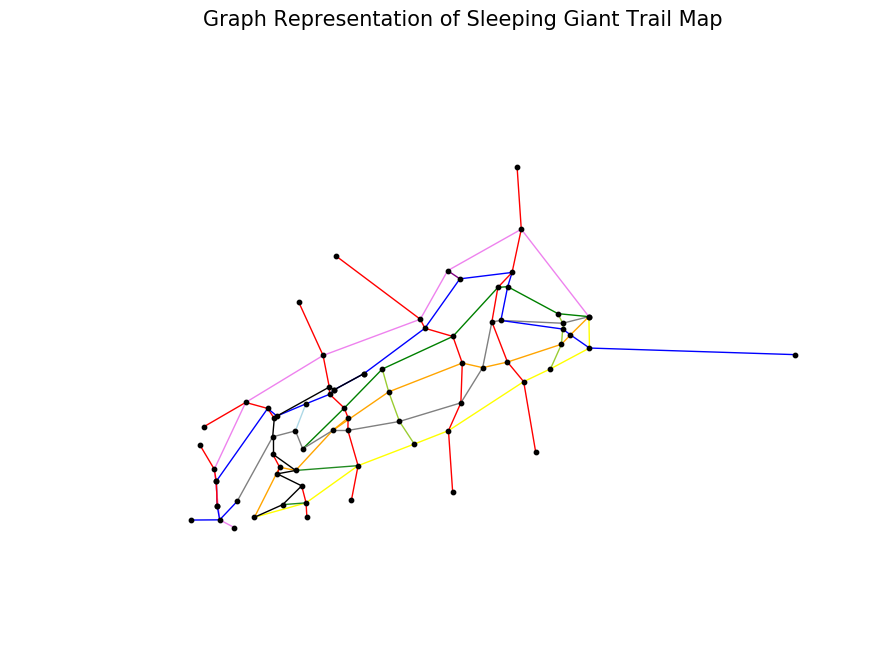

In [67]:
plt.figure(figsize=(8, 6))
nx.draw(g, pos=node_positions, edge_color=edge_colors, node_size=10, node_color='black')
plt.title('Graph Representation of Sleeping Giant Trail Map', size=15)
plt.show()

This graph representation obviously doesn't capture all the trails' bends and squiggles, however not to worry: these are accurately captured in the edge `distance` attribute which is used for computation.  The visual does capture distance between nodes (trail intersections) as the crow flies, which appears to be a decent approximation.

## Overview of CPP Algorithm

OK, so now that you've defined some terms and created the graph, how do you find the shortest path through it?

Solving the Chinese Postman Problem is quite simple conceptually: 

  1. Find all nodes with odd degree (very easy).<br>
  *(Find all trail intersections where the number of trails touching that intersection is an odd number)*  
  <br>

  2. Add edges to the graph such that all nodes of odd degree are made even.  These added edges must be duplicates from the original graph (we'll assume no bushwhacking for this problem).  The set of edges added should sum to the minimum distance possible (hard...np-hard to be precise).<br>
  *(In simpler terms, minimize the amount of double backing on a route that hits every trail)*  
   <br>

  3. Given a starting point, find the Eulerian tour over the augmented dataset (moderately easy).<br>
  *(Once we know which trails we'll be double backing on, actually calculate the route from beginning to end)*

## Assumptions and Simplifications

While a shorter and more precise path could be generated by relaxing the assumptions below, this would add complexity beyond the scope of this tutorial which focuses on the CPP.

**Assumption 1: Required trails only**

As you can see from the trail map above, there are roads along the borders of the park that could be used to connect trails, particularly the red trails.  There are also some trails (Horseshoe and unmarked blazes) which are not required per the [Giantmaster log], but could be helpful to prevent lengthy double backing.  The inclusion of optional trails is actually an established variant of the CPP called the [Rural Postman Problem].  We ignore optional trails in this tutorial and focus on required trails only. 

**Assumption 2: Uphill == downhill** 

The CPP assumes that the cost of walking a trail is equivalent to its distance, regardless of which direction it is walked.  However, some of these trails are rather hilly and will require more energy to walk up than down.  Some metric that combines both distance and elevation change over a directed graph could be incorporated into an extension of the CPP called the [Windy Postman Problem].

**Assumption 3: No parallel edges (trails)**

While possible, the inclusion of parallel edges (multiple trails connecting the same two nodes) adds complexity to computation.  Luckily this only occurs twice here (Blue <=> Red Diamond and Blue <=> Tower Trail).  This is addressed by a bit of a hack to the edge list: duplicate nodes are included with a *_dupe* suffix to capture every trail while maintaining uniqueness in the edges.  The CPP implementation in the [postman_problems] package I wrote robustly handles parallel edges in a more elegant way if you'd like to solve the CPP on your own graph with many parallel edges.


[Rural Postman Problem]: https://en.wikipedia.org/wiki/Route_inspection_problem#Variants
[Windy Postman Problem]: https://en.wikipedia.org/wiki/Route_inspection_problem#Windy_postman_problem
[Giantmaster log]:http://www.sgpa.org/hikes/MasterLog.pdf
[postman_problems]:https://github.com/brooksandrew/postman_problems

## CPP Step 1: Find Nodes of Odd Degree

This is a pretty straightforward counting computation.  You see that 36 of the 76 nodes have odd degree.  These are mostly  the dead-end trails (degree 1) and intersections of 3 trails.  There are a handful of degree 5 nodes.

In [68]:
# Calculate list of nodes with odd degree
# nodes_odd_degree = [v for v, d in g.degree_iter() if d % 2 == 1]  # deprecated after NX 1.11
nodes_odd_degree = [v for v, d in g.degree() if d % 2 == 1]
        
# Preview
nodes_odd_degree[0:5]

['v_end_west',
 'rt_end_north',
 'rh_end_north',
 'rh_end_tt_1',
 'o_y_tt_end_west']

In [69]:
# Counts
print('Number of nodes of odd degree: {}'.format(len(nodes_odd_degree)))
print('Number of total nodes: {}'.format(len(g.nodes())))

Number of nodes of odd degree: 36
Number of total nodes: 77


## CPP Step 2: Find Min Distance Pairs

This is really the meat of the problem.  You'll break it down into 5 parts:

1. Compute all possible pairs of odd degree nodes.  
2. Compute the shortest path between each node pair calculated in **1.**  
3. Create a [complete graph] connecting every node pair in **1.** with shortest path distance attributes calculated in **2.**  
4. Compute a [minimum weight matching] of the graph calculated in **3.** <br>
*(This boils down to determining how to pair the odd nodes such that the sum of the distance between the pairs is as small as possible).*  
5. Augment the original graph with the shortest paths between the node pairs calculated in **4.**

[complete graph]: https://en.wikipedia.org/wiki/Complete_graph
[minimum weight matching]:https://en.wikipedia.org/wiki/Matching_(graph_theory)

### Step 2.1: Compute Node Pairs

You use the `itertools combination` function to compute all possible pairs of the odd degree nodes.  Your graph is undirected, so we don't care about order: For example, `(a,b) == (b,a)`.

In [70]:
# Compute all pairs of odd nodes. in a list of tuples
odd_node_pairs = list(itertools.combinations(nodes_odd_degree, 2))

# Preview pairs of odd degree nodes
odd_node_pairs[0:10]

[('v_end_west', 'rt_end_north'),
 ('v_end_west', 'rh_end_north'),
 ('v_end_west', 'rh_end_tt_1'),
 ('v_end_west', 'o_y_tt_end_west'),
 ('v_end_west', 'b_v'),
 ('v_end_west', 'y_gy2'),
 ('v_end_west', 'nature_end_west'),
 ('v_end_west', 'y_rh'),
 ('v_end_west', 'g_gy2'),
 ('v_end_west', 'b_bv')]

In [71]:
# Counts
print('Number of pairs: {}'.format(len(odd_node_pairs)))

Number of pairs: 630


Let's confirm that this number of pairs is correct with a the combinatoric below.  Luckily, you only have 630 pairs to worry about.  Your computation time to solve this CPP example is trivial (a couple seconds).  

However, if you had 3,600 odd node pairs instead, you'd have ~6.5 million pairs to optimize.  That's a ~10,000x increase in output given a 100x increase in input size.

<script src="https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.0/MathJax.js?config=TeX-AMS-MML_HTMLorMML" type="text/javascript"></script>


$$
\#\;of\;pairs  = n\;choose\;r = {n \choose r} =  \frac{n!}{r!(n-r)!} = \frac{36!}{2! (36-2)!} = 630
$$

### Step 2.2: Compute Shortest Paths between Node Pairs

This is the first step that involves some real computation.  Luckily `networkx` has a convenient implementation of [Dijkstra's algorithm] to compute the shortest path between two nodes.  You apply this function to every pair (all 630) calculated above in `odd_node_pairs`.

[Dijkstra's algorithm]: https://en.wikipedia.org/wiki/Dijkstra%27s_algorithm

In [72]:
def get_shortest_paths_distances(graph, pairs, edge_weight_name):
    """Compute shortest distance between each pair of nodes in a graph.  Return a dictionary keyed on node pairs (tuples)."""
    distances = {}
    for pair in pairs:
        distances[pair] = nx.dijkstra_path_length(graph, pair[0], pair[1], weight=edge_weight_name)
    return distances

In [73]:
# Compute shortest paths.  Return a dictionary with node pairs keys and a single value equal to shortest path distance.
odd_node_pairs_shortest_paths = get_shortest_paths_distances(g, odd_node_pairs, 'distance')

# Preview with a bit of hack (there is no head/slice method for dictionaries).
dict(list(odd_node_pairs_shortest_paths.items())[0:10])

{('b_bv', 'rs_end_north'): 0.8999999999999999,
 ('b_v', 'rh_end_tt_3'): 0.6500000000000001,
 ('g_gy2', 'b_bw'): 1.73,
 ('o_y_tt_end_west', 'rh_end_tt_4'): 0.35,
 ('rd_end_north', 'g_gy1'): 1.37,
 ('rd_end_south', 'b_tt_3'): 1.1300000000000001,
 ('rd_end_south', 'g_gy1'): 1.3,
 ('rh_end_tt_1', 'rd_end_south'): 0.6000000000000001,
 ('rt_end_north', 'rd_end_south'): 1.31,
 ('v_end_west', 'b_end_west'): 0.45}

### Step 2.3: Create Complete Graph 

A [complete graph] is simply a graph where every node is connected to every other node by a unique edge.

Here's a basic example from Wikipedia of a 7 node complete graph with 21 (7 choose 2) edges: 

![title](fig/png/148px-Complete_graph_K7.png)

The graph you create below has 36 nodes and 630 edges with their corresponding edge weight (distance).

`create_complete_graph` is defined to calculate it.  The `flip_weights` parameter is used to transform the `distance` to the `weight` attribute where smaller numbers reflect large distances and high numbers reflect short distances.  This sounds a little counter intuitive, but is necessary for Step **2.4** where you calculate the minimum weight matching on the complete graph.  

Ideally you'd calculate the minimum weight matching directly, but NetworkX only implements a `max_weight_matching` function which maximizes, rather than minimizes edge weight.  We hack this a bit by negating (multiplying by -1) the `distance` attribute to get `weight`. This ensures that order and scale by distance are preserved, but reversed.

[complete graph]: https://en.wikipedia.org/wiki/Complete_graph

In [74]:
def create_complete_graph(pair_weights, flip_weights=True):
    """
    Create a completely connected graph using a list of vertex pairs and the shortest path distances between them
    Parameters: 
        pair_weights: list[tuple] from the output of get_shortest_paths_distances
        flip_weights: Boolean. Should we negate the edge attribute in pair_weights?
    """
    g = nx.Graph()
    for k, v in pair_weights.items():
        wt_i = - v if flip_weights else v
        # g.add_edge(k[0], k[1], {'distance': v, 'weight': wt_i})  # deprecated after NX 1.11 
        g.add_edge(k[0], k[1], **{'distance': v, 'weight': wt_i})  
    return g

In [75]:
# Generate the complete graph
g_odd_complete = create_complete_graph(odd_node_pairs_shortest_paths, flip_weights=True)

# Counts
print('Number of nodes: {}'.format(len(g_odd_complete.nodes())))
print('Number of edges: {}'.format(len(g_odd_complete.edges())))

Number of nodes: 36
Number of edges: 630


For a visual prop, the fully connected graph of odd degree node pairs is plotted below.  Note that you preserve the X, Y coordinates of each node, but the edges do not necessarily represent actual trails.  For example, two nodes could be connected by a single edge in this graph, but the shortest path between them could be 5 hops through even degree nodes (not shown here).

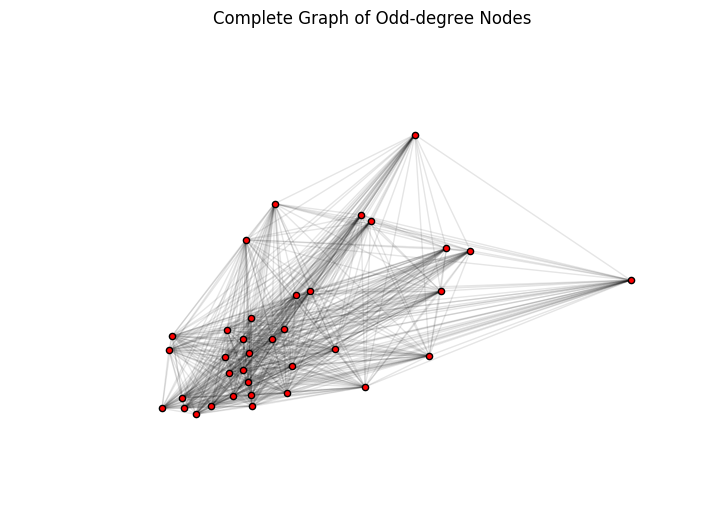

In [76]:
# Plot the complete graph of odd-degree nodes
plt.figure(figsize=(8, 6))
pos_random = nx.random_layout(g_odd_complete)
nx.draw_networkx_nodes(g_odd_complete, node_positions, node_size=20, node_color="red")
nx.draw_networkx_edges(g_odd_complete, node_positions, alpha=0.1)
plt.axis('off')
plt.title('Complete Graph of Odd-degree Nodes')
plt.show()

### Step 2.4: Compute Minimum Weight Matching

This is the most complex step in the CPP.  You need to find the odd degree node pairs whose combined sum (of distance between them) is as small as possible.  So for your problem, this boils down to selecting the optimal 18 edges (36 odd degree nodes / 2) from the hairball of a graph generated in **2.3**.

Both the implementation and intuition of this optimization are beyond the scope of this tutorial... like [800+ lines of code] and a body of academic literature beyond this scope.  

However, a quick aside for the interested reader:

A huge thanks to Joris van Rantwijk for writing the orginal implementation on [his blog] way back in 2008.  I stumbled into the problem a similar way with the same intention as Joris. From Joris's 2008 post:

>  Since I did not find any Perl implementations of maximum weighted matching, I lightly decided to write some code myself.  It turned out that I had underestimated the problem, but by the time I realized my mistake, I was so obsessed with the problem that I refused to give up. 

However, I did give up.  Luckily Joris did not.

This Maximum Weight Matching has since been folded into and maintained within the NetworkX package.  Another big thanks to the [10+ contributors on GitHub] who have maintained this hefty codebase. 

This is a hard and intensive computation.  The first breakthrough in 1965 proved that the Maximum Matching problem could be solved in polynomial time.  It was published by Jack Edmonds with perhaps one of the most beautiful academic paper titles ever: "Paths, trees, and flowers" \[[1]\].    A body of literature has since built upon this work, improving the optimization procedure.  The code implemented in the NetworkX function [max_weight_matching] is based on Galil, Zvi (1986) \[[2]\] which employs an O(n<sup>3</sup>) time algorithm.


[max_weight_matching]: http://networkx.readthedocs.io/en/networkx-1.10/reference/generated/networkx.algorithms.matching.max_weight_matching.html?highlight=max_weight_matching]

[his blog]: http://jorisvr.nl/article/maximum-matching

[10+ contributors on GitHub]:https://github.com/networkx/networkx/blob/master/networkx/algorithms/matching.py

[800+ lines of code]: https://networkx.github.io/documentation/networkx-1.10/_modules/networkx/algorithms/matching.html#max_weight_matching

[1]:https://cms.math.ca/openaccess/cjm/v17/cjm1965v17.0449-0467.pdf
[2]:https://pdfs.semanticscholar.org/6fc3/371dc5d40b638a6b4acb548c8420fa67aac1.pdf


In [77]:
# Compute min weight matching.
# Note: max_weight_matching uses the 'weight' attribute by default as the attribute to maximize.
odd_matching_dupes = nx.algorithms.max_weight_matching(g_odd_complete, True)

print('Number of edges in matching: {}'.format(len(odd_matching_dupes)))

Number of edges in matching: 36


The matching output (`odd_matching_dupes`) is a dictionary.  Although there are 36 edges in this matching, you only want 18.  Each edge-pair occurs twice (once with node 1 as the key and a second time with node 2 as the key of the dictionary).  

In [78]:
# Preview of matching with dupes
odd_matching_dupes

{'b_bv': 'v_bv',
 'b_bw': 'rh_end_tt_1',
 'b_end_east': 'g_gy2',
 'b_end_west': 'b_v',
 'b_tt_3': 'rt_end_north',
 'b_v': 'b_end_west',
 'g_gy1': 'rc_end_north',
 'g_gy2': 'b_end_east',
 'g_w': 'w_bw',
 'nature_end_west': 'o_y_tt_end_west',
 'o_rt': 'o_w_1',
 'o_tt': 'rh_end_tt_2',
 'o_w_1': 'o_rt',
 'o_y_tt_end_west': 'nature_end_west',
 'rc_end_north': 'g_gy1',
 'rc_end_south': 'y_gy1',
 'rd_end_north': 'rh_end_north',
 'rd_end_south': 'v_end_west',
 'rh_end_north': 'rd_end_north',
 'rh_end_south': 'y_rh',
 'rh_end_tt_1': 'b_bw',
 'rh_end_tt_2': 'o_tt',
 'rh_end_tt_3': 'rh_end_tt_4',
 'rh_end_tt_4': 'rh_end_tt_3',
 'rs_end_north': 'v_end_east',
 'rs_end_south': 'y_gy2',
 'rt_end_north': 'b_tt_3',
 'rt_end_south': 'y_rt',
 'v_bv': 'b_bv',
 'v_end_east': 'rs_end_north',
 'v_end_west': 'rd_end_south',
 'w_bw': 'g_w',
 'y_gy1': 'rc_end_south',
 'y_gy2': 'rs_end_south',
 'y_rh': 'rh_end_south',
 'y_rt': 'rt_end_south'}

You convert this dictionary to a list of tuples since you have an undirected graph and order does not matter.  Removing duplicates yields the unique 18 edge-pairs that cumulatively sum to the least possible distance.

In [79]:
# Convert matching to list of deduped tuples
odd_matching = list(pd.unique([tuple(sorted([k, v])) for k, v in odd_matching_dupes.items()]))

# Counts
print('Number of edges in matching (deduped): {}'.format(len(odd_matching)))

Number of edges in matching (deduped): 18


In [80]:
# Preview of deduped matching
odd_matching

[('o_tt', 'rh_end_tt_2'),
 ('nature_end_west', 'o_y_tt_end_west'),
 ('b_tt_3', 'rt_end_north'),
 ('rs_end_south', 'y_gy2'),
 ('b_bw', 'rh_end_tt_1'),
 ('rd_end_south', 'v_end_west'),
 ('b_bv', 'v_bv'),
 ('b_end_west', 'b_v'),
 ('rh_end_south', 'y_rh'),
 ('g_gy1', 'rc_end_north'),
 ('rc_end_south', 'y_gy1'),
 ('rd_end_north', 'rh_end_north'),
 ('rt_end_south', 'y_rt'),
 ('rh_end_tt_3', 'rh_end_tt_4'),
 ('b_end_east', 'g_gy2'),
 ('rs_end_north', 'v_end_east'),
 ('g_w', 'w_bw'),
 ('o_rt', 'o_w_1')]

Let's visualize these pairs on the complete graph plotted earlier in step **2.3**.  As before, while the node positions reflect the true graph (trail map) here, the edge distances shown (blue lines) are as the crow flies.  The actual shortest route from one node to another could involve multiple edges that twist and turn with considerably longer distance.

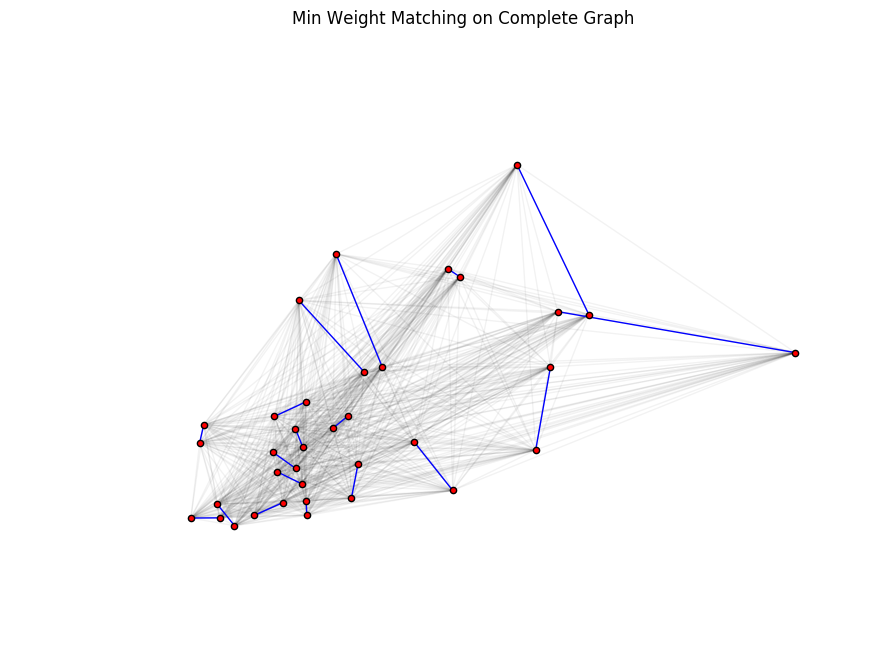

In [81]:
plt.figure(figsize=(8, 6))

# Plot the complete graph of odd-degree nodes
nx.draw(g_odd_complete, pos=node_positions, node_size=20, alpha=0.05)

# Create a new graph to overlay on g_odd_complete with just the edges from the min weight matching
g_odd_complete_min_edges = nx.Graph(odd_matching)
nx.draw(g_odd_complete_min_edges, pos=node_positions, node_size=20, edge_color='blue', node_color='red')

plt.title('Min Weight Matching on Complete Graph')
plt.show()

To illustrate how this fits in with the original graph, you plot the same min weight pairs (blue lines), but over the trail map (faded) instead of the complete graph.  Again, note that the blue lines are the bushwhacking route (as the crow flies edges, not actual trails).  You still have a little bit of work to do to find the edges that comprise the shortest route between each pair in Step **3.**

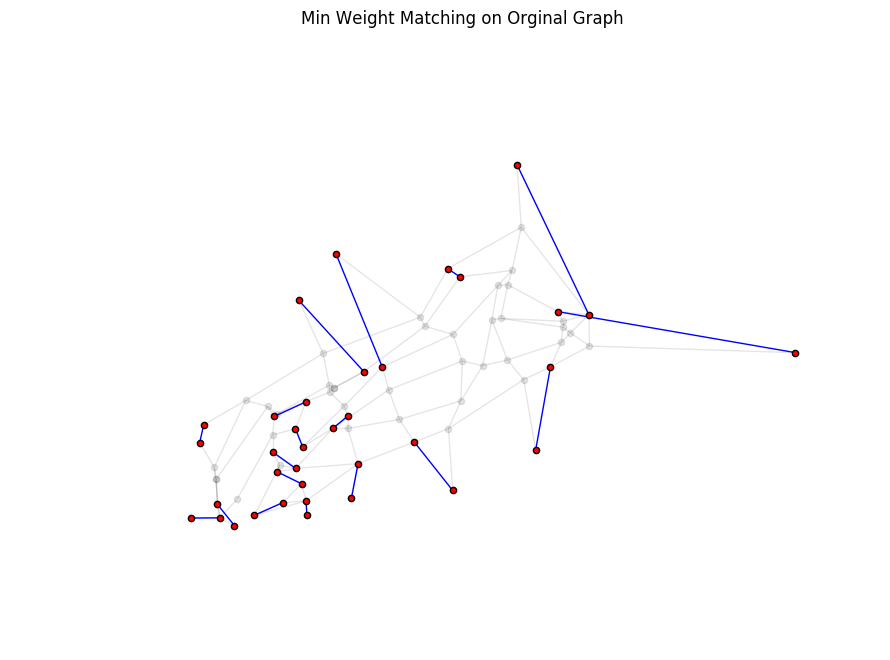

In [82]:
plt.figure(figsize=(8, 6))

# Plot the original trail map graph
nx.draw(g, pos=node_positions, node_size=20, alpha=0.1, node_color='black')

# Plot graph to overlay with just the edges from the min weight matching
nx.draw(g_odd_complete_min_edges, pos=node_positions, node_size=20, alpha=1, node_color='red', edge_color='blue')

plt.title('Min Weight Matching on Orginal Graph')
plt.show()

### Step 2.5: Augment the Original Graph

Now you augment the original graph with the edges from the matching calculated in **2.4**. A simple function to do this is defined below which also notes that these new edges came from the augmented graph.  You'll need to know this in ** 3.** when you actually create the Eulerian circuit through the graph.  

In [83]:
def add_augmenting_path_to_graph(graph, min_weight_pairs):
    """
    Add the min weight matching edges to the original graph
    Parameters:
        graph: NetworkX graph (original graph from trailmap)
        min_weight_pairs: list[tuples] of node pairs from min weight matching
    Returns:
        augmented NetworkX graph
    """
    
    # We need to make the augmented graph a MultiGraph so we can add parallel edges
    graph_aug = nx.MultiGraph(graph.copy())
    for pair in min_weight_pairs:
        graph_aug.add_edge(pair[0], 
                           pair[1], 
                           **{'distance': nx.dijkstra_path_length(graph, pair[0], pair[1]), 'trail': 'augmented'}
                           # attr_dict={'distance': nx.dijkstra_path_length(graph, pair[0], pair[1]),
                           #            'trail': 'augmented'}  # deprecated after 1.11
                          )
    return graph_aug

Let's confirm that your augmented graph adds the expected number (18) of edges:

In [84]:
# Create augmented graph: add the min weight matching edges to g
g_aug = add_augmenting_path_to_graph(g, odd_matching)

# Counts
print('Number of edges in original graph: {}'.format(len(g.edges())))
print('Number of edges in augmented graph: {}'.format(len(g_aug.edges())))

Number of edges in original graph: 123
Number of edges in augmented graph: 141


Let's also confirm that every node now has even degree:

In [85]:
# pd.value_counts(g_aug.degree())  # deprecated after NX 1.11
pd.value_counts([e[1] for e in g_aug.degree()])

4    54
2    18
6     5
dtype: int64

## CPP Step 3: Compute Eulerian Circuit

Now that you have a graph with even degree the hard optimization work is over.  As Euler famously postulated in 1736 with the [Seven Bridges of Königsberg] problem, there exists a path which visits each edge exactly once if all nodes have even degree.  Carl Hierholzer fomally proved this result later in the 1870s.

There are many Eulerian circuits with the same distance that can be constructed.  You can get 90% of the way there with the NetworkX `eulerian_circuit` function.  However there are some limitations.

**Limitations you will fix:**
 1. The augmented graph could (and likely will) contain edges that didn't exist on the original graph.  To get the circuit (without bushwhacking), you must break down these augmented edges into the shortest path through the edges that actually exist.  
 
 2. `eulerian_circuit` only returns the order in which we hit each node.  It does not return the attributes of the edges needed to complete the circuit.  This is necessary because you need to keep track of which edges have been walked already when multiple edges exist between two nodes.
 
 
**Limitations you won't fix:**

<!-- hack to start bulleted list at 3. when separated by text block -->
<ol start="3"> 
 <li>To save your legs some work, you could relax the assumption of the Eulerian circuit that one start and finish at the same node.  An [Eulerian path] (the general case of the Eulerian circuit), can also be found if there are exactly two nodes of odd degree.  This would save you a little bit of double backing...presuming you could get a ride back from the other end of the park.  However, at the time of this writing, NetworkX does not provide a Euler Path algorithm.  The [eulerian_circuit code] isn't too bad and could be adopted for this case, but you'll keep it simple here. </li>
</ol>
 
 
### Naive Circuit

Nonetheless, let's start with the simple yet incomplete solution: 


[Seven Bridges of Königsberg]: https://en.wikipedia.org/wiki/Seven_Bridges_of_K%C3%B6nigsberg
[Eulerian path]: https://en.wikipedia.org/wiki/Eulerian_path
[eulerian_circuit code]: https://networkx.github.io/documentation/networkx-1.10/_modules/networkx/algorithms/euler.html#eulerian_circuit


In [86]:
naive_euler_circuit = list(nx.eulerian_circuit(g_aug, source='b_end_east'))

As expected, the length of the naive Eulerian circuit is equal to the number of the edges in the augmented graph.

In [87]:
print('Length of eulerian circuit: {}'.format(len(naive_euler_circuit)))

Length of eulerian circuit: 141


The output is just a list of tuples which represent node pairs.  Note that the first node of each pair is the same as the second node from the preceding pair.   

In [88]:
# Preview naive Euler circuit
naive_euler_circuit[0:10]

[('b_end_east', 'b_y'),
 ('b_y', 'y_gy2'),
 ('y_gy2', 'rs_end_south'),
 ('rs_end_south', 'y_rs'),
 ('y_rs', 'y_gy2'),
 ('y_gy2', 'o_gy2'),
 ('o_gy2', 'o_rs'),
 ('o_rs', 'o_w_2'),
 ('o_w_2', 'w_rc'),
 ('w_rc', 'y_rc')]

### Correct Circuit

Now let's define a function that utilizes the original graph to tell you which trails to use to get from node A to node B.  Although verbose in code, this logic is actually quite simple.  You simply transform the naive circuit which included edges that did not exist in the original graph to a Eulerian circuit using only edges that exist in the original graph.  

You loop through each edge in the naive Eulerian circuit (`naive_euler_circuit`).  Wherever you encounter an edge that does not exist in the original graph, you replace it with the sequence of edges comprising the shortest path between its nodes using the original graph.

In [89]:
def create_eulerian_circuit(graph_augmented, graph_original, starting_node=None):
    """Create the eulerian path using only edges from the original graph."""
    euler_circuit = []
    naive_circuit = list(nx.eulerian_circuit(graph_augmented, source=starting_node))
    
    for edge in naive_circuit:
        edge_data = graph_augmented.get_edge_data(edge[0], edge[1])    
        
        if edge_data[0]['trail'] != 'augmented':
            # If `edge` exists in original graph, grab the edge attributes and add to eulerian circuit.
            edge_att = graph_original[edge[0]][edge[1]]
            euler_circuit.append((edge[0], edge[1], edge_att)) 
        else: 
            aug_path = nx.shortest_path(graph_original, edge[0], edge[1], weight='distance')
            aug_path_pairs = list(zip(aug_path[:-1], aug_path[1:]))
            
            print('Filling in edges for augmented edge: {}'.format(edge))
            print('Augmenting path: {}'.format(' => '.join(aug_path)))
            print('Augmenting path pairs: {}\n'.format(aug_path_pairs))
            
            # If `edge` does not exist in original graph, find the shortest path between its nodes and 
            #  add the edge attributes for each link in the shortest path.
            for edge_aug in aug_path_pairs:
                edge_aug_att = graph_original[edge_aug[0]][edge_aug[1]]
                euler_circuit.append((edge_aug[0], edge_aug[1], edge_aug_att))
                                      
    return euler_circuit

You hack **limitation 3** a bit by starting the Eulerian circuit at the far east end of the park on the Blue trail (node "b_end_east"). When actually running this thing, you could simply skip the last direction which doubles back on it.

Verbose print statements are added to convey what happens when you replace nonexistent edges from the augmented graph with the shortest path using edges that actually exist.

In [90]:
# Create the Eulerian circuit
euler_circuit = create_eulerian_circuit(g_aug, g, 'b_end_east')

Filling in edges for augmented edge: ('y_gy2', 'rs_end_south')
Augmenting path: y_gy2 => y_rs => rs_end_south
Augmenting path pairs: [('y_gy2', 'y_rs'), ('y_rs', 'rs_end_south')]

Filling in edges for augmented edge: ('rc_end_south', 'y_gy1')
Augmenting path: rc_end_south => y_rc => y_gy1
Augmenting path pairs: [('rc_end_south', 'y_rc'), ('y_rc', 'y_gy1')]

Filling in edges for augmented edge: ('v_end_east', 'rs_end_north')
Augmenting path: v_end_east => v_rs => rs_end_north
Augmenting path pairs: [('v_end_east', 'v_rs'), ('v_rs', 'rs_end_north')]

Filling in edges for augmented edge: ('b_bw', 'rh_end_tt_1')
Augmenting path: b_bw => b_tt_1 => rh_end_tt_1
Augmenting path pairs: [('b_bw', 'b_tt_1'), ('b_tt_1', 'rh_end_tt_1')]

Filling in edges for augmented edge: ('rd_end_south', 'v_end_west')
Augmenting path: rd_end_south => b_v => v_end_west
Augmenting path pairs: [('rd_end_south', 'b_v'), ('b_v', 'v_end_west')]

Filling in edges for augmented edge: ('rh_end_north', 'rd_end_north')
Aug

You see that the length of the Eulerian circuit is longer than the naive circuit, which makes sense.

In [91]:
print('Length of Eulerian circuit: {}'.format(len(euler_circuit)))

Length of Eulerian circuit: 158


## CPP Solution

### Text

Here's a printout of the solution in text: 

In [92]:
# Preview first 20 directions of CPP solution
for i, edge in enumerate(euler_circuit[0:20]):
    print(i, edge)

0 ('b_end_east', 'b_y', {'estimate': 0, 'distance': 1.32, 'color': 'blue', 'trail': 'b'})
1 ('b_y', 'y_gy2', {'estimate': 0, 'distance': 0.28, 'color': 'yellow', 'trail': 'y'})
2 ('y_gy2', 'y_rs', {'estimate': 0, 'distance': 0.16, 'color': 'yellow', 'trail': 'y'})
3 ('y_rs', 'rs_end_south', {'estimate': 0, 'distance': 0.39, 'color': 'red', 'trail': 'rs'})
4 ('rs_end_south', 'y_rs', {'estimate': 0, 'distance': 0.39, 'color': 'red', 'trail': 'rs'})
5 ('y_rs', 'y_gy2', {'estimate': 0, 'distance': 0.16, 'color': 'yellow', 'trail': 'y'})
6 ('y_gy2', 'o_gy2', {'estimate': 0, 'distance': 0.12, 'color': 'yellowgreen', 'trail': 'gy2'})
7 ('o_gy2', 'o_rs', {'estimate': 0, 'distance': 0.33, 'color': 'orange', 'trail': 'o'})
8 ('o_rs', 'o_w_2', {'estimate': 0, 'distance': 0.15, 'color': 'orange', 'trail': 'o'})
9 ('o_w_2', 'w_rc', {'estimate': 0, 'distance': 0.23, 'color': 'gray', 'trail': 'w'})
10 ('w_rc', 'y_rc', {'estimate': 0, 'distance': 0.14, 'color': 'red', 'trail': 'rc'})
11 ('y_rc', 'rc_e

You can tell pretty quickly that the algorithm is not very loyal to any particular trail, jumping from one to the next pretty quickly.  An extension of this approach could get fancy and build in some notion of trail loyalty into the objective function to make actually running this route more manageable.

### Stats

Let's peak into your solution to see how reasonable it looks.<br>
*(Not important to dwell on this verbose code, just the printed output)*

In [43]:
# Computing some stats
total_mileage_of_circuit = sum([edge[2]['distance'] for edge in euler_circuit])
total_mileage_on_orig_trail_map = sum(nx.get_edge_attributes(g, 'distance').values())
_vcn = pd.value_counts(pd.value_counts([(e[0]) for e in euler_circuit]), sort=False)
node_visits = pd.DataFrame({'n_visits': _vcn.index, 'n_nodes': _vcn.values})
_vce = pd.value_counts(pd.value_counts([sorted(e)[0] + sorted(e)[1] for e in nx.MultiDiGraph(euler_circuit).edges()]))
edge_visits = pd.DataFrame({'n_visits': _vce.index, 'n_edges': _vce.values})

# Printing stats
print('Mileage of circuit: {0:.2f}'.format(total_mileage_of_circuit))
print('Mileage on original trail map: {0:.2f}'.format(total_mileage_on_orig_trail_map))
print('Mileage retracing edges: {0:.2f}'.format(total_mileage_of_circuit-total_mileage_on_orig_trail_map))
print('Percent of mileage retraced: {0:.2f}%\n'.format((1-total_mileage_of_circuit/total_mileage_on_orig_trail_map)*-100))

print('Number of edges in circuit: {}'.format(len(euler_circuit)))
print('Number of edges in original graph: {}'.format(len(g.edges())))
print('Number of nodes in original graph: {}\n'.format(len(g.nodes())))

print('Number of edges traversed more than once: {}\n'.format(len(euler_circuit)-len(g.edges())))  

print('Number of times visiting each node:')
print(node_visits.to_string(index=False))

print('\nNumber of times visiting each edge:')
print(edge_visits.to_string(index=False))

Mileage of circuit: 33.59
Mileage on original trail map: 25.76
Mileage retracing edges: 7.83
Percent of mileage retraced: 30.40%

Number of edges in circuit: 158
Number of edges in original graph: 123
Number of nodes in original graph: 77

Number of edges traversed more than once: 35

Number of times visiting each node:
n_nodes  n_visits
     18         1
     38         2
     20         3
      1         4

Number of times visiting each edge:
n_edges  n_visits
     88         1
     35         2


## Visualize CPP Solution

While NetworkX also provides functionality to visualize graphs, they are [notably humble] in this department:

> NetworkX provides basic functionality for visualizing graphs, but its main goal is to enable graph analysis rather than perform graph visualization. In the future, graph visualization functionality may be removed from NetworkX or only available as an add-on package.  

>Proper graph visualization is hard, and we highly recommend that people visualize their graphs with tools dedicated to that task. Notable examples of dedicated and fully-featured graph visualization tools are Cytoscape, Gephi, Graphviz and, for LaTeX typesetting, PGF/TikZ.

That said, the built-in NetworkX drawing functionality with matplotlib is powerful enough for eyeballing and visually exploring basic graphs, so you stick with NetworkX `draw` for this tutorial.  

I used [graphviz] and the [dot] graph description language to visualize the solution in my Python package [postman_problems].  Although it took some legwork to convert the NetworkX graph structure to a dot graph, it does unlock enhanced quality and control over visualizations. 


### Create CPP Graph

Your first step is to convert the list of edges to walk in the Euler circuit into an edge list with plot-friendly attributes.

`create_cpp_edgelist` Creates an edge list with some additional attributes that you'll use for plotting:
* **sequence:** records a sequence of when we walk each edge.
* **visits:** is simply the number of times we walk a particular edge.


[notably humble]: https://networkx.github.io/documentation/networkx-1.10/reference/drawing.html
[graphviz]:http://www.graphviz.org/
[dot]:https://en.wikipedia.org/wiki/DOT_(graph_description_language)
[postman_problems]: https://github.com/brooksandrew/postman_problems


In [44]:
def create_cpp_edgelist(euler_circuit):
    """
    Create the edgelist without parallel edge for the visualization
    Combine duplicate edges and keep track of their sequence and # of walks
    Parameters:
        euler_circuit: list[tuple] from create_eulerian_circuit
    """
    cpp_edgelist = {}

    for i, e in enumerate(euler_circuit):
        edge = frozenset([e[0], e[1]])

        if edge in cpp_edgelist:
            cpp_edgelist[edge][2]['sequence'] += ', ' + str(i)
            cpp_edgelist[edge][2]['visits'] += 1

        else:
            cpp_edgelist[edge] = e
            cpp_edgelist[edge][2]['sequence'] = str(i)
            cpp_edgelist[edge][2]['visits'] = 1
        
    return list(cpp_edgelist.values())

Let's create the CPP edge list:

In [45]:
cpp_edgelist = create_cpp_edgelist(euler_circuit)

As expected, your edge list has the same number of edges as the original graph.

In [46]:
print('Number of edges in CPP edge list: {}'.format(len(cpp_edgelist)))

Number of edges in CPP edge list: 123


The CPP edge list looks similar to `euler_circuit`, just with a few additional attributes.

In [47]:
# Preview CPP plot-friendly edge list
cpp_edgelist[0:3]

[('o_w_2',
  'w_rs',
  {'color': 'gray',
   'distance': 0.26,
   'estimate': 0,
   'sequence': '79',
   'trail': 'w',
   'visits': 1}),
 ('y_rc',
  'rc_end_south',
  {'color': 'red',
   'distance': 0.36,
   'estimate': 0,
   'sequence': '11, 12',
   'trail': 'rc',
   'visits': 2}),
 ('o_w_1',
  'o_rt',
  {'color': 'orange',
   'distance': 0.13,
   'estimate': 0,
   'sequence': '51, 52',
   'trail': 'o',
   'visits': 2})]

Now let's make the graph:

In [48]:
# Create CPP solution graph
g_cpp = nx.Graph(cpp_edgelist)

### Visualization 1: Retracing Steps

<p>Here you illustrate which edges are walked once (<span style="color:gray">gray</span>) and more than once (<span style="color:blue">blue</span>).  This is the "correct" version of the visualization created in <b>2.4</b> which showed the naive (as the crow flies) connections between the odd node pairs (<span style="color:red">red</span>).  That is corrected here by tracing the shortest path through edges that actually exist for each pair of odd degree nodes.</p>  

If the optimization is any good, these blue lines should represent the least distance possible.  Specifically, the minimum distance needed to generate a [matching] of the odd degree nodes.

[matching]:https://en.wikipedia.org/wiki/Matching_(graph_theory)

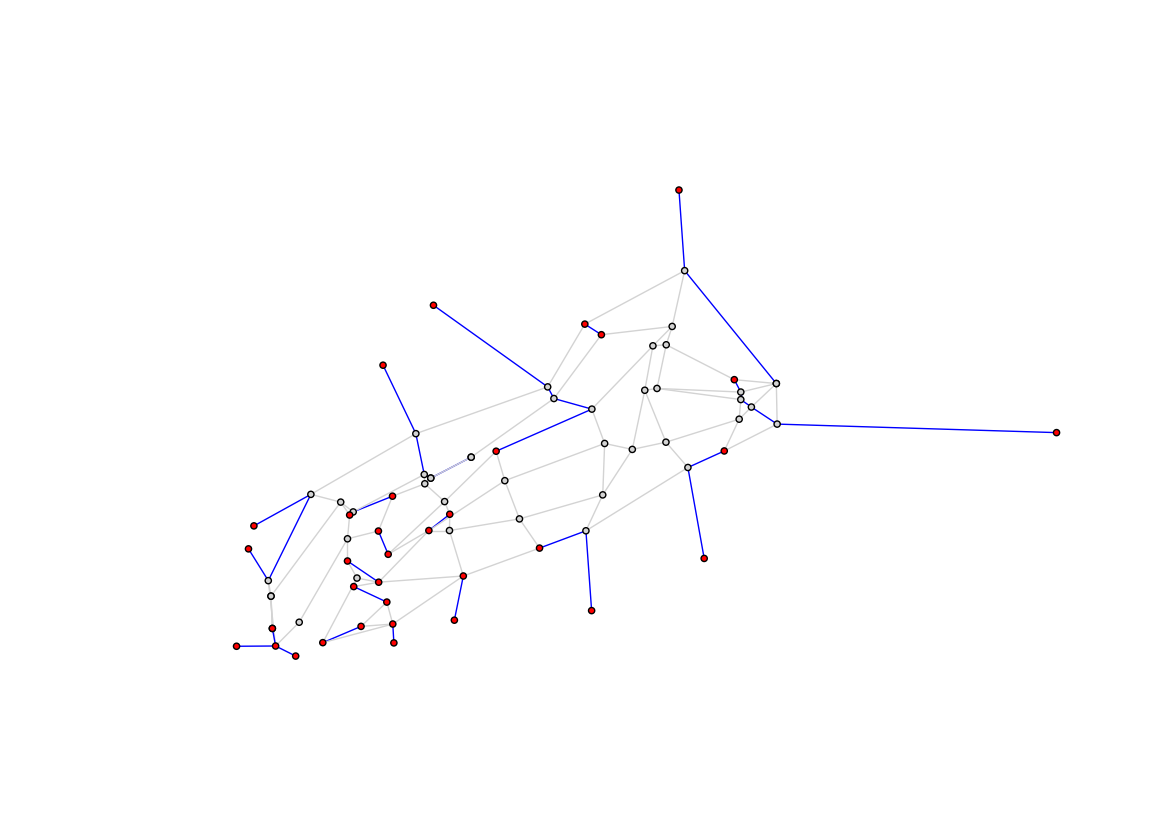

In [49]:
plt.figure(figsize=(14, 10))

visit_colors = {1:'lightgray', 2:'blue'}
edge_colors = [visit_colors[e[2]['visits']] for e in g_cpp.edges(data=True)]
node_colors = ['red'  if node in nodes_odd_degree else 'lightgray' for node in g_cpp.nodes()]

nx.draw_networkx(g_cpp, pos=node_positions, node_size=20, node_color=node_colors, edge_color=edge_colors, with_labels=False)
plt.axis('off')
plt.show()

### Visualization 2: CPP Solution Sequence

Here you plot the original graph (trail map) annotated with the sequence numbers in which we walk the trails per the CPP solution.  Multiple numbers indicate trails we must double back on.

You start on the blue trail in the bottom right (0th and the 157th direction).

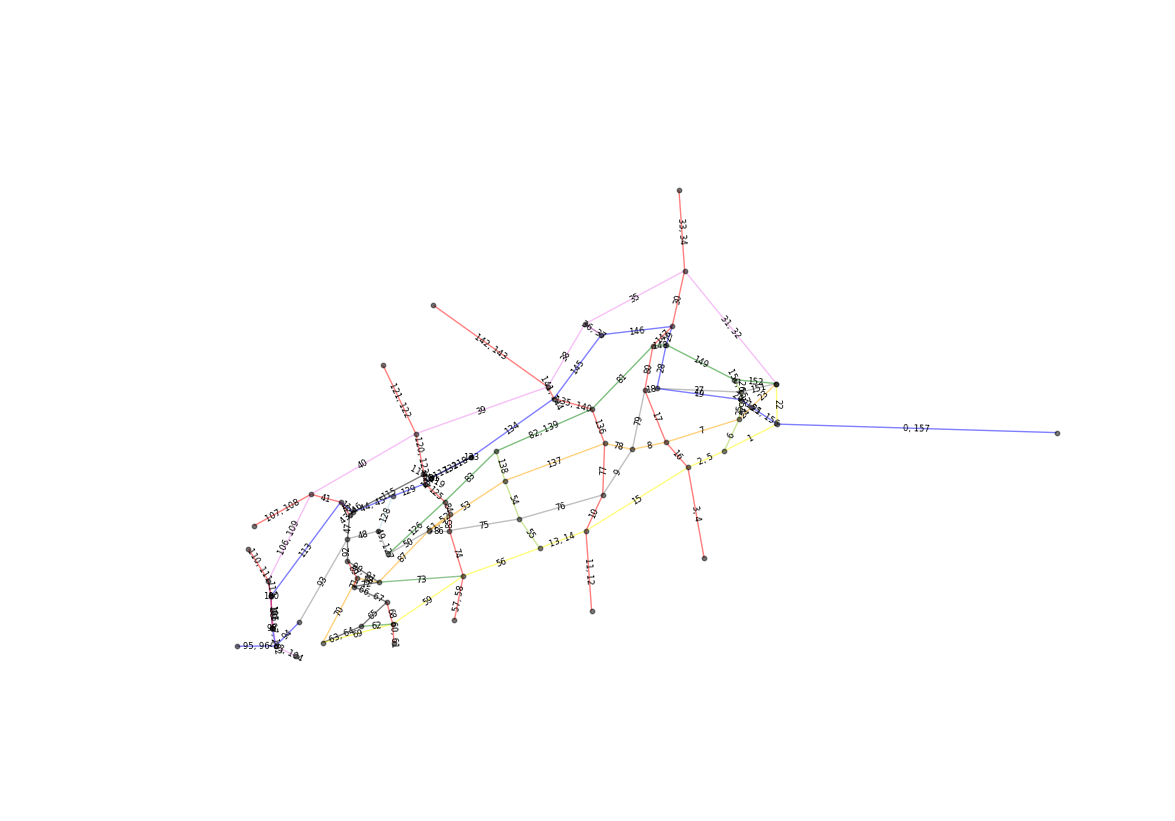

In [50]:
plt.figure(figsize=(14, 10))

edge_colors = [e[2]['color'] for e in g_cpp.edges(data=True)]
nx.draw_networkx(g_cpp, pos=node_positions, node_size=10, node_color='black', edge_color=edge_colors, with_labels=False, alpha=0.5)

bbox = {'ec':[1,1,1,0], 'fc':[1,1,1,0]}  # hack to label edges over line (rather than breaking up line)
edge_labels = nx.get_edge_attributes(g_cpp, 'sequence')
nx.draw_networkx_edge_labels(g_cpp, pos=node_positions, edge_labels=edge_labels, bbox=bbox, font_size=6)

plt.axis('off')
plt.show()


### Visualization 3: Movie

The movie below that traces the Euler circuit from beginning to end is embedded below.  Edges are colored black the first time they are walked and <span style="color:red">red</span> the second time.

Note that this gif doesn't do give full visual justice to edges which overlap another or are too small to visualize properly.  A more robust visualization library such as graphviz could address this by plotting splines instead of straight lines between nodes.

The code that creates it is presented below as a reference.

![Alt Text](https://gist.githubusercontent.com/brooksandrew/2a70bbc88899791241cfb88be1372f44/raw/87d1a0ce438d6f4d9a23ce89df2984cbe30ba993/sleeping_giant_cpp_route_animation.gif)

First a PNG image is produced for each direction (edge walked) from the CPP solution.

In [ ]:
visit_colors = {1:'black', 2:'red'}
edge_cnter = {}
g_i_edge_colors = []
for i, e in enumerate(euler_circuit, start=1):

    edge = frozenset([e[0], e[1]])
    if edge in edge_cnter:
        edge_cnter[edge] += 1
    else:
        edge_cnter[edge] = 1

    # Full graph (faded in background)
    nx.draw_networkx(g_cpp, pos=node_positions, node_size=6, node_color='gray', with_labels=False, alpha=0.07)

    # Edges walked as of iteration i
    euler_circuit_i = copy.deepcopy(euler_circuit[0:i])
    for i in range(len(euler_circuit_i)):
        edge_i = frozenset([euler_circuit_i[i][0], euler_circuit_i[i][1]])
        euler_circuit_i[i][2]['visits_i'] = edge_cnter[edge_i]
    g_i = nx.Graph(euler_circuit_i)
    g_i_edge_colors = [visit_colors[e[2]['visits_i']] for e in g_i.edges(data=True)]

    nx.draw_networkx_nodes(g_i, pos=node_positions, node_size=6, alpha=0.6, node_color='lightgray', with_labels=False, linewidths=0.1)
    nx.draw_networkx_edges(g_i, pos=node_positions, edge_color=g_i_edge_colors, alpha=0.8)

    plt.axis('off')
    plt.savefig('fig/png/img{}.png'.format(i), dpi=120, bbox_inches='tight')
    plt.close()

Then the the PNG images are stitched together to make the nice little gif above.

First the PNGs are sorted in the order from 0 to 157.  Then they are stitched together using `imageio` at 3 frames per second to create the gif.

In [ ]:
import glob
import numpy as np
import imageio
import os

def make_circuit_video(image_path, movie_filename, fps=5):
    # sorting filenames in order
    filenames = glob.glob(image_path + 'img*.png')
    filenames_sort_indices = np.argsort([int(os.path.basename(filename).split('.')[0][3:]) for filename in filenames])
    filenames = [filenames[i] for i in filenames_sort_indices]

    # make movie
    with imageio.get_writer(movie_filename, mode='I', fps=fps) as writer:
        for filename in filenames:
            image = imageio.imread(filename)
            writer.append_data(image)

make_circuit_video('fig/png/', 'fig/gif/cpp_route_animation.gif', fps=3)

## Next Steps

Congrats, you have finished this tutorial solving the Chinese Postman Problem in Python. You have covered a lot of ground in this tutorial (33.6 miles of trails to be exact).  For a deeper dive into network fundamentals, you might be interested in Datacamp's [Network Analysis in Python] course which provides a more thorough treatment of the core concepts.  

Don't hesitate to check out the [NetworkX documentation] for more on how to create, manipulate and traverse these complex networks.  The docs are comprehensive with a good number of [examples] and a series of [tutorials]. 

If you're interested in solving the CPP on your own graph, I've packaged the functionality within this tutorial into the [postman_problems] Python package on Github. You can also piece together the code blocks from this tutorial with a different edge and node list, but the postman_problems package will probably get you there more quickly and cleanly.

One day I plan to implement the extensions of the CPP (Rural and Windy Postman Problem) here as well. I also have grand ambitions of writing about these extensions and experiences testing the routes out on the trails on my blog [here]. Another application I plan to explore and write about is incorporating lat/long coordinates to develop (or use) a mechanism to send turn-by-turn directions to my Garmin watch.

And of course one last next step: getting outside and trail running the route!

[postman_problems]:https://github.com/brooksandrew/postman_problems
[Network Analysis in Python]:https://www.datacamp.com/courses/network-analysis-in-python-part-1
[NetworkX documentation]:http://networkx.readthedocs.io/en/stable/overview.html
[examples]:http://networkx.readthedocs.io/en/stable/examples/index.html
[tutorials]:http://networkx.readthedocs.io/en/stable/tutorial/index.html
[here]:http://brooksandrew.github.io/simpleblog/

## References

[1]: Edmonds, Jack (1965). "Paths, trees, and flowers". Canad. J. Math. 17: 449–467.  <br>
[2]: Galil, Z. (1986). "Efficient algorithms for finding maximum matching in graphs". ACM Computing Surveys. Vol. 18, No. 1: 23-38.